In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


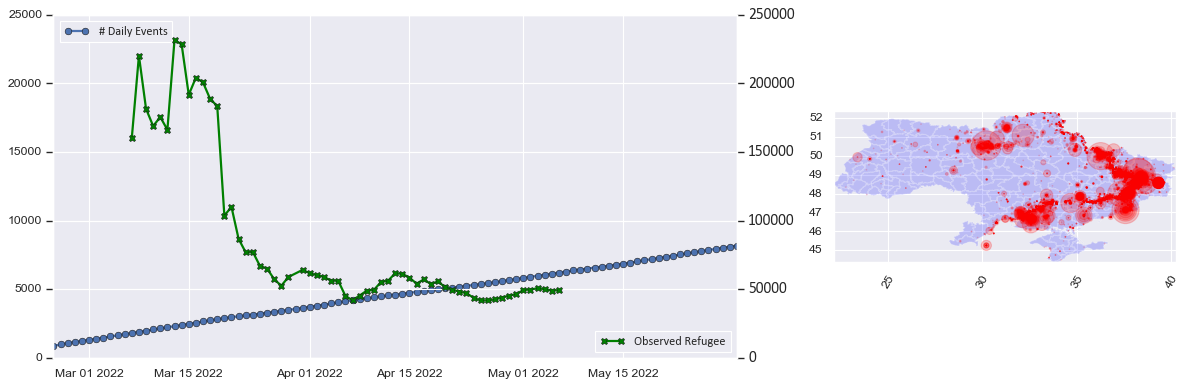

In [3]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [4]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [5]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df


trapped_raions = pd.read_csv('entrapped.csv')
def get_trap_results(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):

    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        if cur_id not in trapped_raions['Raion'].tolist():
            cur_hyper_comb = hyper_comb - 2000
        else:
            cur_hyper_comb = hyper_comb
        
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(cur_hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(cur_hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_non_trap_results(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):

    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        if cur_id not in trapped_raions['Raion'].tolist():
            cur_hyper_comb = hyper_comb
        else:
            cur_hyper_comb = hyper_comb+1000
        
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(cur_hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(cur_hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [6]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [7]:
r1 = get_raion_list(99950,prefix='mim_result')
r2 = get_raion_list(500,prefix='mim_result')
r1-r2

{'Berehivskyi',
 'Chortkivskyi',
 'Kovelskyi',
 'Krasnohvardiiskyi',
 'Krasnoperekopskyi',
 'Rozdilnianskyi',
 'Tiachivskyi',
 'Yaltynskyi'}

In [8]:
# HOUSEHOLD_DATA_PREFIX = 'ukraine_household_data_ADM2_HDX.csv'
# hh_df = pd.read_csv(HOUSEHOLD_DIR+HOUSEHOLD_DATA_PREFIX)
# hh_df.shape

In [9]:
# hh_cnt = hh_df['matching_place_id'].value_counts().reset_index().rename(columns={'index':'raion','matching_place_id':'hh'})

In [10]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3

#simulation_indices = [10060,10061,10062,10063,10064,10065,10066,10067,10068,10069]
#simulation_indices = [30000,30001,30002,30003,30004,30005,30006]
#simulation_indices = [40000,40001,40002,40003,40004,40005,40006]
#simulation_indices = [50000,50001,50002,50003,50004,50005,50006]
#simulation_indices = [50006,50007,50008,50009,50010,50011]
#simulation_indices = [2000,2001,2004,2005]


In [12]:
import json

samples = []
with open('../ukraine_next_step_calibration_peer_effect_int/logs/bayes_examples_all_log_revised.json', 'r') as file:
    for line in file:
        samples.append(json.loads(line))

good = []
max_err = -40000

param_dicts = []
good_hyper_combs = []
for i in range(0,len(samples)):
    tt = samples[i]['target']
    if tt>max_err:
        #print()
        param_dicts.append(samples[i]['params'])
        good_hyper_combs.append(7000+i)
#print(param_dicts)
print(good_hyper_combs)

[7020, 7023, 7024, 7025, 7026, 7028, 7031, 7037, 7038, 7045, 7049, 7050, 7052, 7057, 7059, 7061, 7065, 7066, 7069, 7070, 7074, 7078, 7081, 7094, 7096, 7099, 7101, 7104, 7106, 7109, 7110, 7119, 7121, 7123, 7124, 7127, 7129, 7134, 7136, 7140, 7142, 7143, 7149, 7159, 7160, 7163, 7166, 7185, 7188, 7189, 7193, 7194, 7195]


In [13]:
# import json

# samples = []
# with open('./logs/bayes_examples_all_log_revised.json', 'r') as file:
#     for line in file:
#         samples.append(json.loads(line))

# good = []
# max_err = -50000

# for i in range(0,len(samples)):
#     tt = samples[i]['target']
#     if tt>max_err:
#         good.append(i)
# print(good)

In [14]:
# rmse_1 = []
# rmse_2 = []



# for i in range(0,len(good)):
#     res = get_results_for_2(5000+good[i],prefix='mim_result',partition=20,scale_1=1.0,scale_2=1.0)
#     comp_df = res.merge(refugee_data,on='time',how='inner')
#     comp_df['diff'] = (comp_df['refugee_y']-comp_df['refugee_x'])**2
#     rmse = ((comp_df[5:10]['diff'].sum()+comp_df[50:55]['diff'].sum())/10)**0.5 #10 data points
#     rmse_full = ((comp_df['diff'].sum())/comp_df.shape[0])**0.5 #10 data points
#     rmse_1.append(rmse)
#     rmse_2.append(rmse_full)
#     print(good[i],rmse,rmse_full)
#     #ax.plot(rmse,rmse)


In [15]:
import warnings
warnings.filterwarnings('ignore')

simulation_indices = [6000+i for i in good]
simulation_indices = [6000,7000]
first_df = []
second_df = []

for vv in good_hyper_combs:
    try:
        print(vv,end=' ')
        #current_df = get_trap_results(vv,prefix='mim_result',ROLL=ROLLING,partition=15,scale_1=0.8,scale_2=1.25)
        current_df = get_trap_results(vv,prefix='mim_result',ROLL=ROLLING,partition=20,scale_1=1.0,scale_2=1.5)
        current_df['comb'] = str(vv)
        #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
        #current_df_unsmoothed['comb'] = str(vv)

        first_df.append(current_df)
    except:
        continue
    #second_df.append(current_df_unsmoothed)
first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

7020 112 raions found
7023 112 raions found
7024 112 raions found
7025 112 raions found
7026 112 raions found
7028 112 raions found
7031 112 raions found
7037 112 raions found
7038 112 raions found
7045 113 raions found
7049 112 raions found
7050 112 raions found
7052 112 raions found
7057 112 raions found
7059 112 raions found
7061 112 raions found
7065 112 raions found
7066 112 raions found
7069 112 raions found
7070 113 raions found
7074 112 raions found
7078 112 raions found
7081 112 raions found
7094 113 raions found
7096 112 raions found
7099 112 raions found
7101 112 raions found
7104 112 raions found
7106 112 raions found
7109 112 raions found
7110 112 raions found
7119 112 raions found
7121 112 raions found
7123 112 raions found
7124 112 raions found
7127 113 raions found
7129 112 raions found
7134 111 raions found
7136 113 raions found
7140 112 raions found
7142 112 raions found
7143 110 raions found
7149 105 raions found
7159 110 raions found
7160 112 raions found
7163 112 r

In [16]:
import warnings
warnings.filterwarnings('ignore')

original_indices = [i-2000 for i in good_hyper_combs]

orig_df = []

for vv in original_indices:
    try:
        print(vv,end=' ')
        #current_df = get_trap_results(vv,prefix='mim_result',ROLL=ROLLING,partition=15,scale_1=0.8,scale_2=1.25)
        current_df = get_non_trap_results(vv,prefix='mim_result',ROLL=ROLLING,partition=20,scale_1=1.0,scale_2=1.2)
        current_df['comb'] = str(vv)
        #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
        #current_df_unsmoothed['comb'] = str(vv)

        orig_df.append(current_df)
    except:
        continue
    #second_df.append(current_df_unsmoothed)
orig_df = pd.concat(orig_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

5020 112 raions found
5023 112 raions found
5024 112 raions found
5025 112 raions found
5026 112 raions found
5028 112 raions found
5031 112 raions found
5037 112 raions found
5038 112 raions found
5045 113 raions found
5049 112 raions found
5050 112 raions found
5052 112 raions found
5057 112 raions found
5059 112 raions found
5061 112 raions found
5065 112 raions found
5066 112 raions found
5069 112 raions found
5070 113 raions found
5074 112 raions found
5078 112 raions found
5081 112 raions found
5094 113 raions found
5096 112 raions found
5099 112 raions found
5101 112 raions found
5104 112 raions found
5106 112 raions found
5109 112 raions found
5110 112 raions found
5119 112 raions found
5121 112 raions found
5123 112 raions found
5124 112 raions found
5127 113 raions found
5129 112 raions found
5134 112 raions found
5136 113 raions found
5140 112 raions found
5142 112 raions found
5143 113 raions found
5149 112 raions found
5159 112 raions found
5160 112 raions found
5163 112 r

In [17]:
refugee_data_2 = pd.read_csv('../ABM_model_Ukraine/ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
refugee_data_2 = refugee_data_2[refugee_data_2.time>pd.to_datetime('2022-05-05')]
refugee_data_2.at[71, 'refugee'] = 49355.571429

In [18]:
refugee_data_full = pd.read_csv('ukr_refugee_full.csv')
refugee_data_full['refugee'] = refugee_data_full['Cumulative Refugees'].diff()
refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
refugee_data_full['time'] = pd.to_datetime(refugee_data_full['Date'])
refugee_data_full = refugee_data_full.sort_values(by='time')
refugee_data_full['refugee'] = refugee_data_full['refugee'].rolling(ROLLING).mean()
refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
#refugee_data_full
# refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
# refugee_data_2 = refugee_data_2.sort_values(by='time')
# refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
# refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# # refugee_data['refugee'] = refugee_data['refugee'].diff()
# # refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data_2

## Do specifying different cores and memory change result apart from stochasticity?

In [19]:
refugee_data['refugee'].sum()

5160175.142857144

6000 '6000'
7000 '7000'


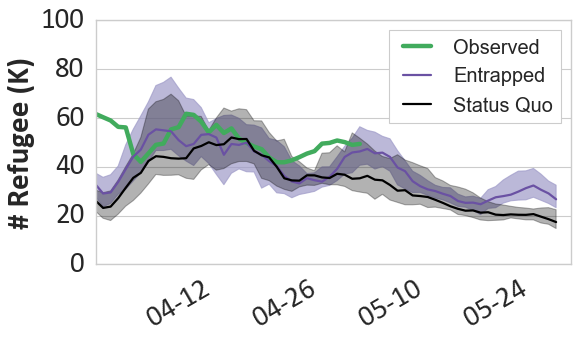

In [167]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(good_hyper_combs[0:20],first_df,q1=0.3,q3=0.7)
median_prev,q1_prev,q3_prev = get_uncertainty(original_indices[0:20],orig_df,q1=0.25,q3=0.75)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(8,5))
plt.xticks(rotation=30)

ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=4,color='#2ca25f')

for p in simulation_indices:
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        #ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8,label=str(p))
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
ax.plot(first_df['time'][0:-2],median_normal.shift(-2)[0:-2]/1000,linewidth=2,color='#6a51a3',alpha=1,label='Entrapped')
ax.fill_between(first_df["time"][0:-2], q1_normal.shift(-2)[0:-2]/1000, q3_normal.shift(-2)[0:-2]/1000, color='#9e9ac8',alpha=0.7)


ax.plot(orig_df['time'][0:-2],median_prev.shift(-2)[0:-2]/1000,linewidth=2,color='black',alpha=1,label='Status Quo')
ax.fill_between(orig_df["time"][0:-2], q1_prev.shift(-2)[0:-2]/1000, q3_prev.shift(-2)[0:-2]/1000, color='black',alpha=0.3)

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 4, 1), datetime.date(2022, 6, 3)])
ax.set_ylim([0,100])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
#fig.savefig('../Figures/iaai_abm_result.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

In [168]:
(median_normal-refugee_data['refugee'])

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
89   NaN
90   NaN
91   NaN
92   NaN
93   NaN
Length: 94, dtype: float64

6000 '6000'
7000 '7000'


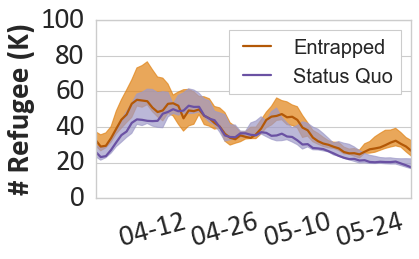

In [21]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(good_hyper_combs[0:20],first_df,q1=0.4,q3=0.7)
median_prev,q1_prev,q3_prev = get_uncertainty(original_indices[0:20],orig_df,q1=0.4,q3=0.7)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(6,4))
plt.xticks(rotation=15)

#ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=4,color='#2ca25f')

for p in simulation_indices:
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        #ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8,label=str(p))
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
ax.plot(first_df['time'][0:-2],median_normal.shift(-2)[0:-2]/1000,linewidth=2,color='#b35806',alpha=1,label='Entrapped')
ax.fill_between(first_df["time"][0:-2], q1_normal.shift(-2)[0:-2]/1000, q3_normal.shift(-2)[0:-2]/1000, color='#e08214',alpha=0.7)


ax.plot(orig_df['time'][0:-2],median_prev.shift(-2)[0:-2]/1000,linewidth=2,color='#6a51a3',alpha=1,label='Status Quo')
ax.fill_between(orig_df["time"][0:-2], q1_prev.shift(-2)[0:-2]/1000, q3_prev.shift(-2)[0:-2]/1000, color='#9e9ac8',alpha=0.7)

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 4, 1), datetime.date(2022, 6, 1)])
ax.set_ylim([0,100])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
fig.savefig('../Figures/iaai_case_study_total.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

In [22]:
entrapped_raions = pd.read_csv('entrapped.csv')
r_list = entrapped_raions['Raion'].tolist()
trap_start_date = pd.to_datetime(entrapped_raions['date_start']).tolist()
trap_start_end = pd.to_datetime(entrapped_raions['date_end']).tolist()

In [23]:
def get_pivoted_results(region,simulations):
    cur_df = []
    for v in simulations:
        #print(v)
        try:
            sim_df = get_results_for_2(v,region_name =[region], prefix='mim_result',ROLL=7,partition=20,scale_1=1.0,scale_2=1.0)
            sim_df['comb'] = str(v)
            cur_df.append(sim_df)
        except:
            continue
    return pd.concat(cur_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [128]:
trapped_hyper_combs = good_hyper_combs[0:5]
non_trapped_hyper_combs = [i-1000 for i in trapped_hyper_combs]
print(trapped_hyper_combs)
print(non_trapped_hyper_combs)


[7020, 7023, 7024, 7025, 7026]
[6020, 6023, 6024, 6025, 6026]


In [129]:
# non_trapped_hyper_combs = [5020]
# trapped_hyper_combs = [6020]

Shostkynskyi
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
Kharkivskyi
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
Chuhuivskyi
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
Kupianskyi
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
Iziumskyi
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
Shchastynskyi
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
1 raions found
Alchevskyi
1 raions found
1 

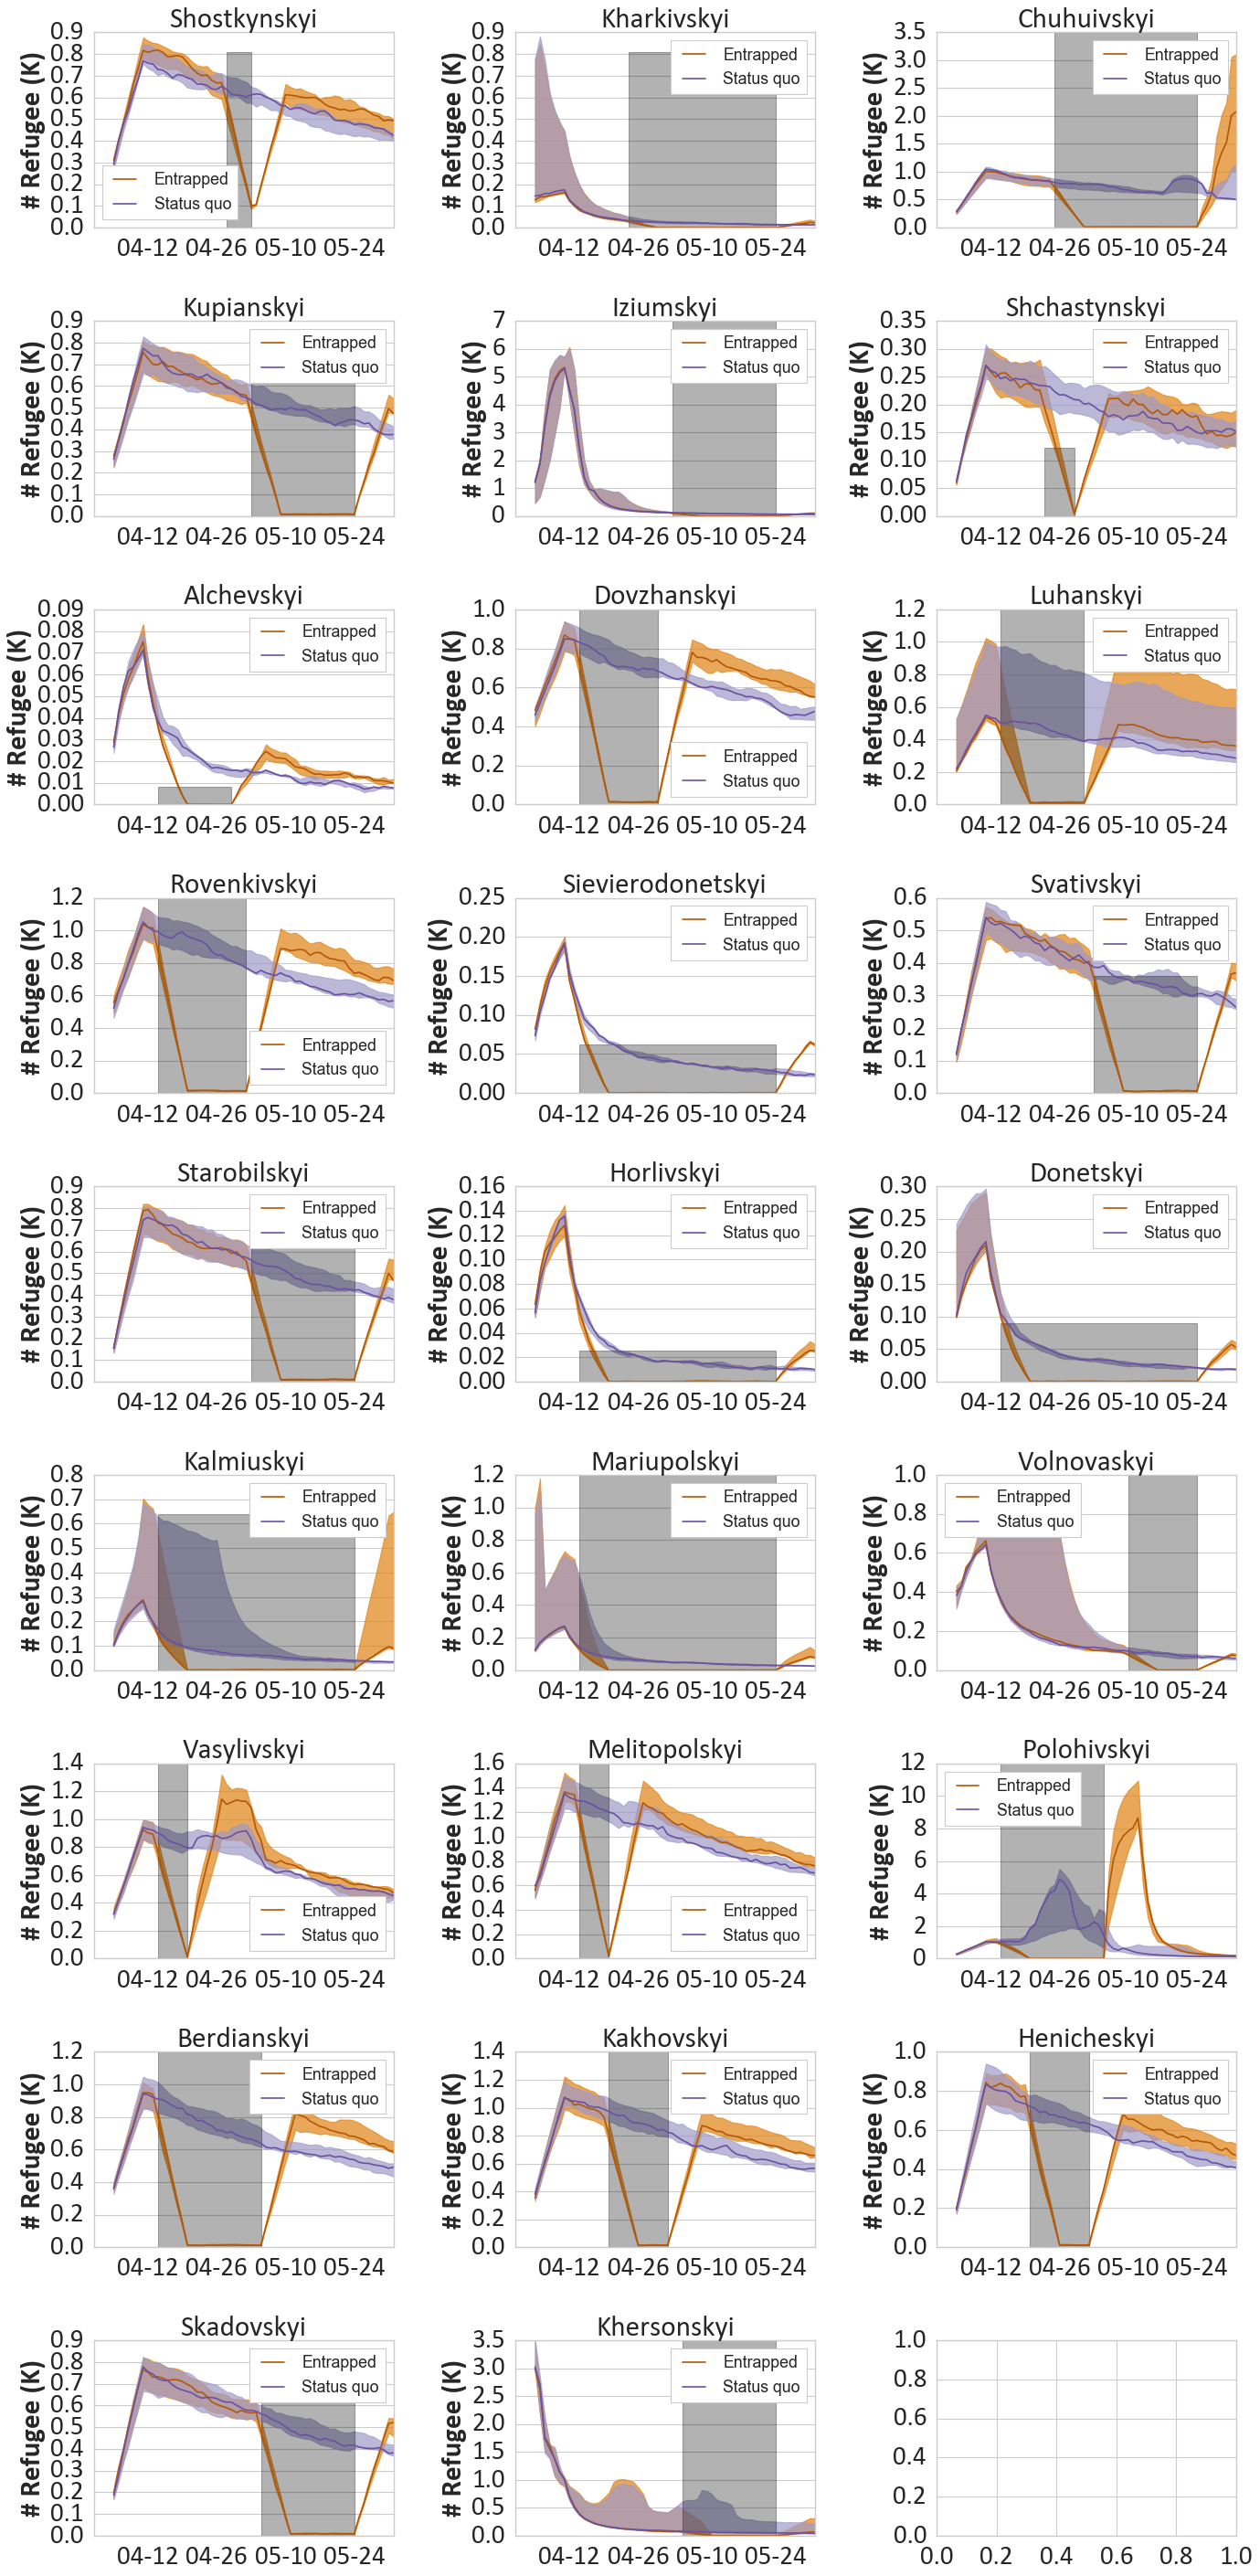

In [135]:
import datetime

trim = 7

#good = []



median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.3,q3=0.7)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

rrr = 9
ccc = 3
#plt.xticks(rotation=15)
fig,ax = plt.subplots(rrr,ccc,figsize=(6*ccc,4*rrr))
#plt.xticks(rotation=15)

for idx,r in enumerate(r_list):
    print(r)
    
    
    trapped_runs = get_pivoted_results(r,trapped_hyper_combs)
    non_trapped_runs = get_pivoted_results(r,non_trapped_hyper_combs)
    
    median_trapped,q1_trapped,q3_trapped = get_uncertainty(trapped_hyper_combs,trapped_runs,q1=0.3,q3=0.7)
    median_not_trapped,q1_not_trapped,q3_not_trapped = get_uncertainty(non_trapped_hyper_combs,non_trapped_runs,q1=0.3,q3=0.7)
    
    #ax.plot(first_df['time'][0:-2],median_normal.shift(-2)[0:-2]/1000,linewidth=2,color='#b35806',alpha=1,label='Entrapped')
    #ax.fill_between(first_df["time"][0:-2], q1_normal.shift(-2)[0:-2]/1000, q3_normal.shift(-2)[0:-2]/1000, color='#e08214',alpha=0.7)


    #ax.plot(orig_df['time'][0:-2],median_prev.shift(-2)[0:-2]/1000,linewidth=2,color='#6a51a3',alpha=1,label='Status Quo')
    #ax.fill_between(orig_df["time"][0:-2], q1_prev.shift(-2)[0:-2]/1000, q3_prev.shift(-2)[0:-2]/1000, color='#9e9ac8',alpha=0.7)

    
    ax[idx//ccc][idx%ccc].plot(trapped_runs['time'][-60:],median_trapped[-60:]/1000,color='#b35806',label='Entrapped')
    ax[idx//ccc][idx%ccc].fill_between(trapped_runs["time"][-60:], q1_trapped[-60:]/1000, q3_trapped[-60:]/1000, color='#e08214',alpha=0.7)

    ax[idx//ccc][idx%ccc].plot(non_trapped_runs['time'][-60:],median_not_trapped[-60:]/1000,label='Status quo',color='#6a51a3')
    ax[idx//ccc][idx%ccc].fill_between(non_trapped_runs[-60:]["time"], q1_not_trapped[-60:]/1000, q3_not_trapped[-60:]/1000, color='#9e9ac8',alpha=0.7)

    myFmt = mdates.DateFormatter('%m-%d')
    ax[idx//ccc][idx%ccc].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[idx//ccc][idx%ccc].xaxis.set_major_formatter(myFmt)

    #ax.set_facecolor("white")
    sns.set_style('whitegrid')

    ax[idx//ccc][idx%ccc].legend(loc='best',ncol=1,fontsize=16)
    ax[idx//ccc][idx%ccc].set_ylabel("# Refugee (K)",fontweight='bold')
    ax[idx//ccc][idx%ccc].set_xlim([datetime.date(2022, 4, 1), datetime.date(2022, 6, 1)])
    ax[idx//ccc][idx%ccc].set_title(r)
    #ax.set_ylim([0,12])
    ymin,ymax = ax[idx//ccc][idx%ccc].get_ylim()
    ax[idx//ccc][idx%ccc].grid(axis='x')
    ax[idx//ccc][idx%ccc].axvspan(trap_start_date[idx], trap_start_end[idx], 
            label="Labeled",color="black", alpha=0.3, ymin=0, ymax=ymax)
    #print(ax.get_xticks())
    
    #fig.savefig('../Figures/iaai_case_study_raion.pdf',dpi=350,bbox_inches='tight')
    #5110 porjonto bhalo
fig.tight_layout()
fig.savefig('../Figures/iaai_raion_entrapped.pdf',bbox_inches='tight',dpi=350)

## Analyzing sample agents

In [138]:
Raion = 'Polohivskyi'
ID = 5020
action_history_df = pd.read_csv(OUTPUT_DIR+'hh_action_history_'+str(Raion)+'_'+str(ID).zfill(5)+'.csv')
action_history_df['time'] = pd.to_datetime(action_history_df['time'])
household_that_moved = action_history_df[action_history_df.decision==1]['hid'].tolist()
move_sample_df = action_history_df[action_history_df.hid.isin(household_that_moved)]
stay_sample_df = action_history_df[~action_history_df.hid.isin(household_that_moved)]

HOUSEHOLD_DATA_PREFIX = 'ukraine_household_data_ADM2_HDX.csv'

In [139]:
total_household_data = pd.read_csv(HOUSEHOLD_DIR+HOUSEHOLD_DATA_PREFIX)

In [140]:
def get_event_weight(event_type,sub_event_type):
    if sub_event_type=='none':
        return 0
    if event_type=="Battles":
        return 3
    if event_type.startswith('Civilian'):
        return 8
    if event_type.startswith('Explosions'):
        return 5
    if event_type.startswith('Violence'):
        return 3
    if event_type.startswith('Protests') or event_type.startswith('Riots'):
        return 0
    return 0

CONFLICT_DATA_PREFIX = 'ukraine_conflict_data_ADM2_HDX_buffer_'
total_impact_data = pd.read_csv(IMPACT_DIR+CONFLICT_DATA_PREFIX+str(5)+'_km.csv')
impact_data = total_impact_data[total_impact_data.matching_place_id==Raion]
impact_data['time'] = pd.to_datetime(impact_data['time'])
impact_count = impact_data.groupby('time')['event_id'].count().reset_index()
impact_data['event_weight'] = impact_data.apply(lambda x: get_event_weight(x['event_type'],x['sub_event_type']),axis=1)
impact_data['severity'] = impact_data['event_weight']*(impact_data['event_intensity']+0.0001)*0.987

In [151]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    KM = 6372.8 #Radius of earth in km instead of miles
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    total_km = KM * c
    return total_km


def get_impact_metric_from_house(hh_id,impact_data,shift=11):
    cur_action_history_df = action_history_df[action_history_df.hid==hh_id][['hid','h_lat','h_lng']].drop_duplicates()
    impact_data['h_lat'] = cur_action_history_df['h_lat'].tolist()[0]
    impact_data['h_lng'] = cur_action_history_df['h_lng'].tolist()[0]
    impact_data['dis'] = haversine(impact_data['longitude'],impact_data['latitude'],impact_data['h_lng'],impact_data['h_lat'])
    impact_data['impact'] = impact_data['severity']/impact_data['dis']**3.9015104451769216
    impact_with_dis_time = impact_data.groupby('time')['impact'].sum().reset_index()
    impact_with_dis_time['impact'] = impact_with_dis_time['impact'].shift(shift)
    impact_with_dis_time = impact_with_dis_time.dropna(subset=['impact'])
    return impact_with_dis_time

# def get_event_weights(hh_id,impact_data,shift=13):
#     impact_with_dis_time = impact_data.groupby('time')['severity'].max().reset_index()
#     impact_with_dis_time['severity'] = impact_with_dis_time['severity'].shift(shift)
#     impact_with_dis_time = impact_with_dis_time.dropna(subset=['severity'])
#     return impact_with_dis_time


## fear

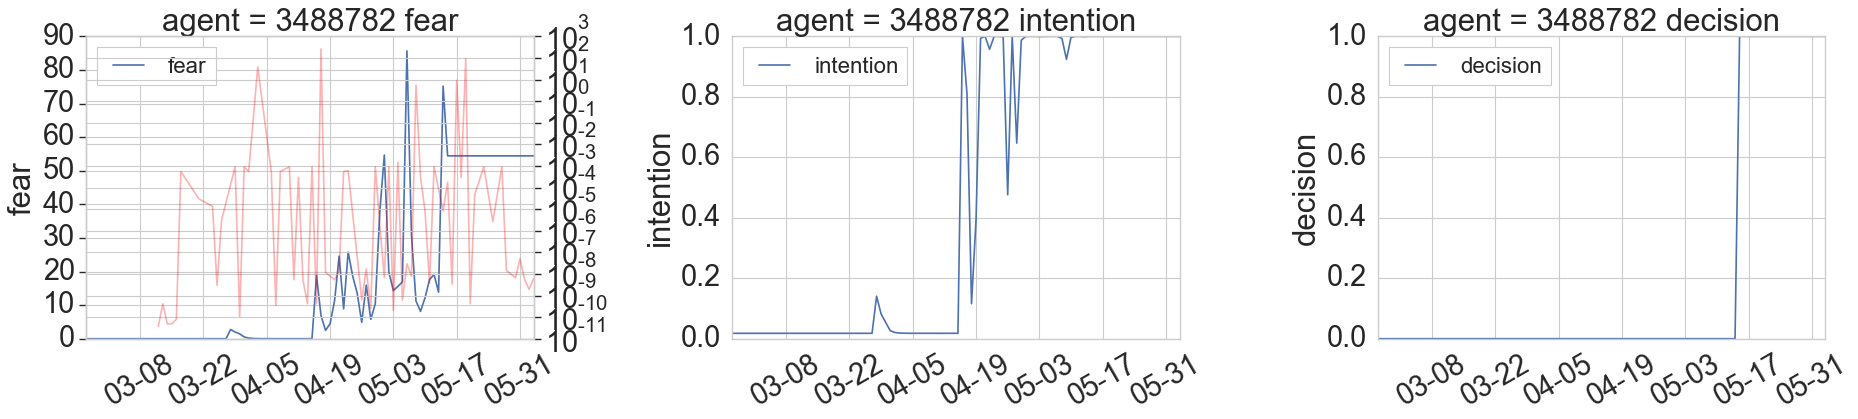

In [152]:
current_household = 3488782

pivot_fear_df = move_sample_df.pivot(index='time',columns='hid',values='fear').ffill().reset_index()
pivot_move_df = move_sample_df.pivot(index='time',columns='hid',values='decision').ffill().reset_index()
pivot_intention_df = move_sample_df.pivot(index='time',columns='hid',values='intention').ffill().reset_index()
pivot_neighbors_df = move_sample_df.pivot(index='time',columns='hid',values='neighbors').fillna(0).reset_index()

hh_impact_dis = get_impact_metric_from_house(current_household,impact_data)
hh_impact_dis = hh_impact_dis.merge(stay_sample_df[['time']],on='time',how='inner')

fig,ax = plt.subplots(1,3,figsize=(8*3,6))
plt.xticks(rotation=30)

ax[0].plot(pivot_fear_df['time'],pivot_fear_df[current_household],label='fear')
ax2 = ax[0].twinx()
ax2.plot(hh_impact_dis['time'],hh_impact_dis['impact'],color='red',alpha=0.3)
ax2.set_yscale('log')
ax[1].plot(pivot_intention_df['time'],pivot_intention_df[current_household],label='intention')
ax[2].plot(pivot_move_df['time'],pivot_move_df[current_household],label='decision')
#ax[3].plot(pivot_neighbors_df['time'],pivot_neighbors_df[any_other_household],label='neighbors')

history = ['fear','intention','decision','neighbors']

myFmt = mdates.DateFormatter('%m-%d')
for i in range(3):
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_title('agent = '+str(current_household)+' '+history[i])
    ax[i].set_ylabel(history[i])
    ax[i].legend(loc='best',fontsize=20)
    ax[i].tick_params('x',labelrotation=30)
    
fig.tight_layout()

In [153]:
total_household_data[total_household_data.hid==16632011]

,hid,OLD_PERSON,CHILD,ADULT_MALE,ADULT_FEMALE,rlid,latitude,longitude,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,admin1,admin2,matching_place_id
16576680,16632011,1,1,0,0,16621531,47.256722,35.712949,Polohivskyi,UA2310,Zaporizka,UA23,140003834,160024654,Polohivskyi


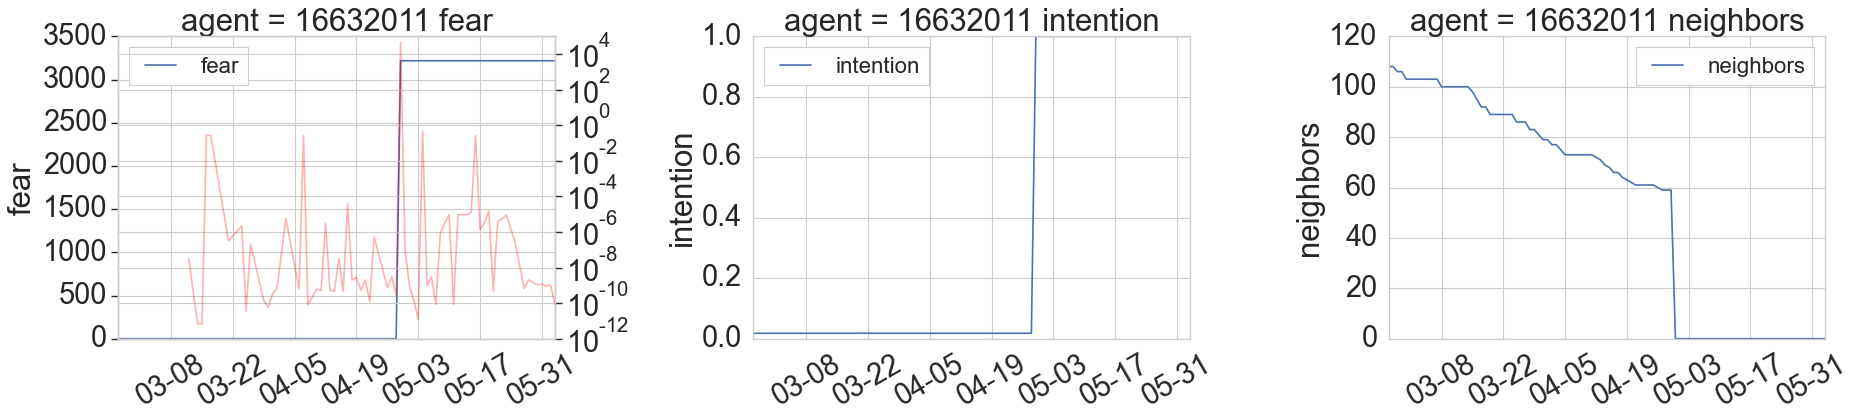

In [164]:
current_household = 16632011

pivot_fear_df = move_sample_df.pivot(index='time',columns='hid',values='fear').ffill().reset_index()
pivot_move_df = move_sample_df.pivot(index='time',columns='hid',values='decision').ffill().reset_index()
pivot_intention_df = move_sample_df.pivot(index='time',columns='hid',values='intention').ffill().reset_index()
pivot_neighbors_df = move_sample_df.pivot(index='time',columns='hid',values='neighbors').fillna(0).reset_index()

hh_impact_dis = get_impact_metric_from_house(current_household,impact_data)
hh_impact_dis = hh_impact_dis.merge(stay_sample_df[['time']],on='time',how='inner')

fig,ax = plt.subplots(1,3,figsize=(8*3,6))
plt.xticks(rotation=30)

ax[0].plot(pivot_fear_df['time'],pivot_fear_df[current_household],label='fear')
#ax[0].set_yscale('log')
ax2 = ax[0].twinx()
ax2.plot(hh_impact_dis['time'],hh_impact_dis['impact'],color='red',alpha=0.3)
ax2.set_yscale('log')
ax[1].plot(pivot_intention_df['time'],pivot_intention_df[current_household],label='intention')
#ax[2].plot(pivot_move_df['time'],pivot_move_df[current_household],label='decision')
ax[2].plot(pivot_neighbors_df['time'],pivot_neighbors_df[current_household],label='neighbors')
#ax[3].plot(pivot_neighbors_df['time'],pivot_neighbors_df[any_other_household],label='neighbors')

history = ['fear','intention','neighbors','decision']

myFmt = mdates.DateFormatter('%m-%d')
for i in range(3):
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_title('agent = '+str(current_household)+' '+history[i])
    ax[i].set_ylabel(history[i])
    ax[i].legend(loc='best',fontsize=20)
    ax[i].tick_params('x',labelrotation=30)
    
fig.tight_layout()

In [104]:
hh_with_max_fear = stay_sample_df[stay_sample_df.fear==stay_sample_df['fear'].max()]['hid'].tolist()[0]
print(hh_with_max_fear)

any_other_household = stay_sample_df.sample(1)['hid'].tolist()[0]
print(any_other_household)

14666784
14061171


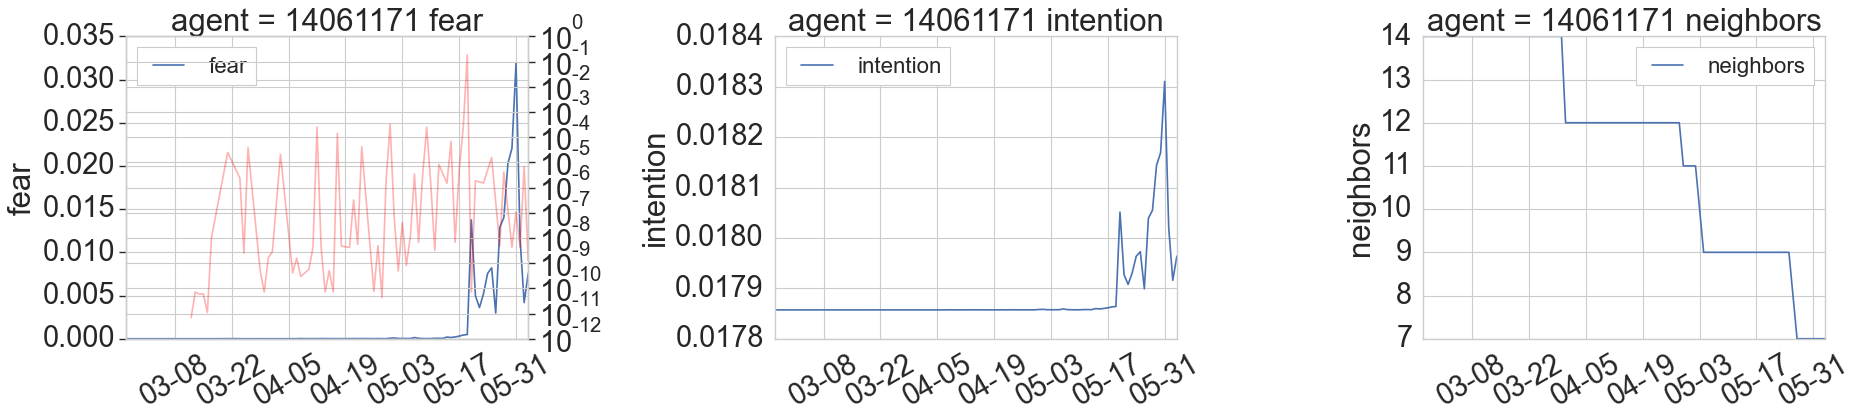

In [162]:
current_household = 14061171

pivot_fear_df = stay_sample_df.pivot(index='time',columns='hid',values='fear').ffill().reset_index()
pivot_move_df = stay_sample_df.pivot(index='time',columns='hid',values='decision').ffill().reset_index()
pivot_intention_df = stay_sample_df.pivot(index='time',columns='hid',values='intention').ffill().reset_index()
pivot_neighbors_df = stay_sample_df.pivot(index='time',columns='hid',values='neighbors').fillna(0).reset_index()

hh_impact_dis = get_impact_metric_from_house(current_household,impact_data)
hh_impact_dis = hh_impact_dis.merge(stay_sample_df[['time']],on='time',how='inner')

fig,ax = plt.subplots(1,3,figsize=(8*3,6))
plt.xticks(rotation=30)

ax[0].plot(pivot_fear_df['time'],pivot_fear_df[current_household],label='fear')
ax2 = ax[0].twinx()
ax2.plot(hh_impact_dis['time'],hh_impact_dis['impact'],color='red',alpha=0.3)
ax2.set_yscale('log')
ax[1].plot(pivot_intention_df['time'],pivot_intention_df[current_household],label='intention')
#ax[2].plot(pivot_move_df['time'],pivot_move_df[current_household],label='decision')
ax[2].plot(pivot_neighbors_df['time'],pivot_neighbors_df[current_household],label='neighbors')

history = ['fear','intention','neighbors','neighbors']

myFmt = mdates.DateFormatter('%m-%d')
for i in range(3):
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_title('agent = '+str(current_household)+' '+history[i])
    ax[i].set_ylabel(history[i])
    ax[i].legend(loc='best',fontsize=20)
    ax[i].tick_params('x',labelrotation=30)
    
fig.tight_layout()

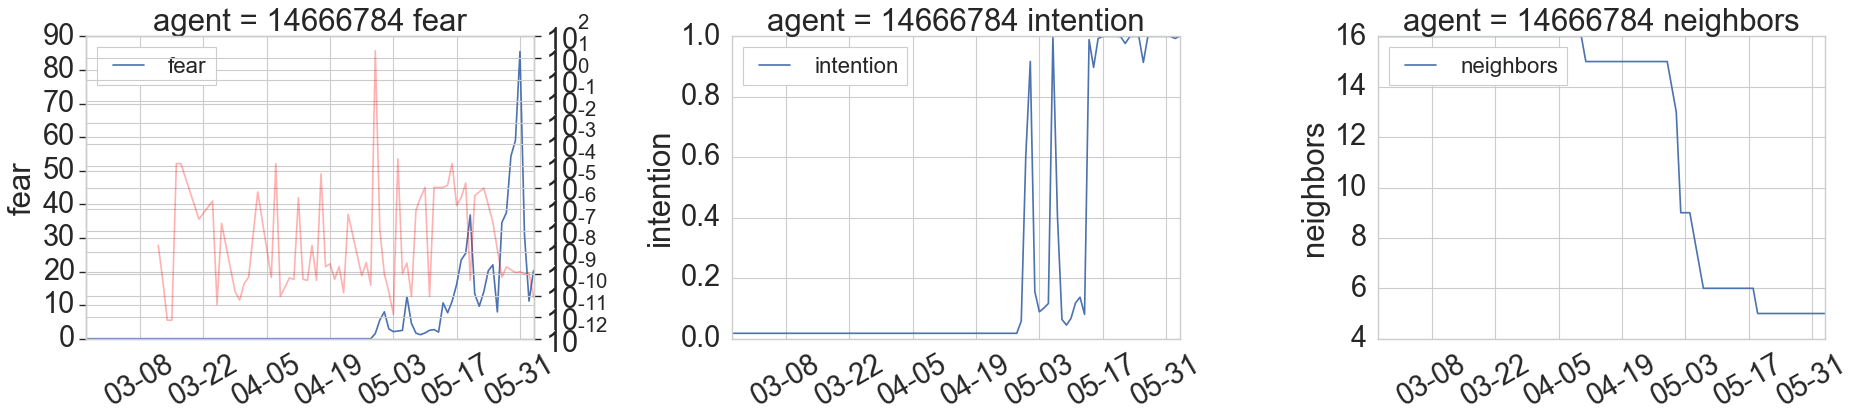

In [165]:
current_household = 14666784

pivot_fear_df = stay_sample_df.pivot(index='time',columns='hid',values='fear').ffill().reset_index()
pivot_move_df = stay_sample_df.pivot(index='time',columns='hid',values='decision').ffill().reset_index()
pivot_intention_df = stay_sample_df.pivot(index='time',columns='hid',values='intention').ffill().reset_index()
pivot_neighbors_df = stay_sample_df.pivot(index='time',columns='hid',values='neighbors').fillna(0).reset_index()

hh_impact_dis = get_impact_metric_from_house(current_household,impact_data)
hh_impact_dis = hh_impact_dis.merge(stay_sample_df[['time']],on='time',how='inner')

fig,ax = plt.subplots(1,3,figsize=(8*3,6))
plt.xticks(rotation=30)

ax[0].plot(pivot_fear_df['time'],pivot_fear_df[current_household],label='fear')
ax2 = ax[0].twinx()
ax2.plot(hh_impact_dis['time'],hh_impact_dis['impact'],color='red',alpha=0.3)
ax2.set_yscale('log')
ax[1].plot(pivot_intention_df['time'],pivot_intention_df[current_household],label='intention')
#ax[2].plot(pivot_move_df['time'],pivot_move_df[current_household],label='decision')
ax[2].plot(pivot_neighbors_df['time'],pivot_neighbors_df[current_household],label='neighbors')

history = ['fear','intention','neighbors','neighbors']

myFmt = mdates.DateFormatter('%m-%d')
for i in range(3):
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_title('agent = '+str(current_household)+' '+history[i])
    ax[i].set_ylabel(history[i])
    ax[i].legend(loc='best',fontsize=20)
    ax[i].tick_params('x',labelrotation=30)
    
fig.tight_layout()

In [106]:
pivot_fear_df[current_household].tail(20)

80    0.000137
81    0.000203
82    0.000294
83    0.000427
84    0.000481
85    0.013751
86    0.004978
87    0.003604
88    0.005219
89    0.007558
90    0.008207
91    0.002971
92    0.012906
93    0.014016
94    0.020294
95    0.022039
96    0.031913
97    0.011552
98    0.004182
99    0.007569
Name: 14061171, dtype: float64

In [107]:
0.36199339728302377*0.031913

0.011552295287493136